In [1]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('D:/Documents/Machine learning/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


On fait le split test/train des données

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.20)

On calcule la moyenne des notes sur le jeu d'apprentissage et on centre les notes

In [12]:
moy=np.mean(train_data['rating'])
train_data['rating']=train_data['rating']-moy
test_data['rating']=test_data['rating']-moy

C:\Users\moosb\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\moosb\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


On crée les matrices de notes

In [13]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Faisons la SVD :

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt


#  fonction qui permet de calculer l'erreur
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


from scipy.sparse.linalg import svds

u, s, vt = svds(train_data_matrix, k = 50)


# On remet bien les valeurs propres de la plus grande à la plus petite
u=u[:,::-1]
s=s[::-1]
vt=vt[::-1,:]

s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 1.0544937547702578


Traçons la courbe des erreurs en fonction du nombre de facteurs choisi :

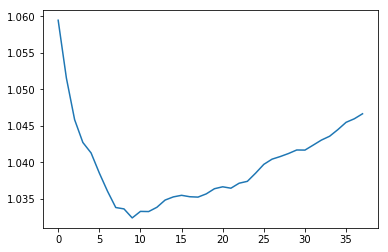

In [15]:
error=list()
for i in range(2,40):
    s_diag_matrix=np.diag(s[:i])
    X_pred = np.dot(np.dot(u[:,0:i], s_diag_matrix), vt[0:i])
    error.append(rmse(X_pred, test_data_matrix))
from matplotlib import pyplot as plt

plt.plot(error)  
plt.show()

On voit qu'on a une erreur minimale pour 9 facteurs proche de 1.033

Mettons en oeuvre les moindres carrés alternés. Créons la matrice avec des 0 si la note est manquante :

In [18]:
W = train_data_matrix>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

Wt = test_data_matrix>0.5
Wt[Wt == True] = 1
Wt[Wt == False] = 0
# To be consistent with our Q matrix
Wt = Wt.astype(np.float64, copy=False)

In [19]:
from scipy.sparse.linalg import svds

n_factors = 3
lambda_ = 0.1
m, n = train_data_matrix.shape
n_iterations = 20



u, s, vt = svds(train_data_matrix, k = n_factors)
u=u[:,::-1]# taille (943,3)
s=s[::-1] # vect col taille 3
vt=vt[::-1,:] # taille (3,1682)


def get_error(Q, X, Y, W):
    return sqrt(np.sum((W * (Q - np.dot(X, Y)))**2)/np.sum(W))

In [20]:
weighted_errors = []
for ii in range(n_iterations):
    for j, Wj in enumerate(W.T):# fixe u et optimise v (parcours des films)
        XtWX =np.dot(u.T, np.dot(np.diag(Wj), u))
        vt[:,j] = np.linalg.solve(XtWX + lambda_ * np.eye(n_factors),
                               np.dot(u.T, np.dot(np.diag(Wj), train_data_matrix[:,j])))
    for i, Wi in enumerate(W):# fixe v et optimise u (parcours des utilisateurs)
        YWYt =np.dot(vt, np.dot(np.diag(Wi), vt.T))
        u[i] = np.linalg.solve(YWYt + lambda_ * np.eye(n_factors),
                                 np.dot(vt, np.dot(np.diag(Wi), train_data_matrix[i].T))).T
  
    weighted_errors.append(get_error(test_data_matrix, u, vt, Wt))
    print('{}th iteration is completed, error : {}'.format(ii,weighted_errors[ii]))

0th iteration is completed, error : 0.7883130997391392
1th iteration is completed, error : 0.5226036611070222
2th iteration is completed, error : 0.4919903155172628
3th iteration is completed, error : 0.4653156021823319
4th iteration is completed, error : 0.4281262708884803
5th iteration is completed, error : 0.3942613521460103
6th iteration is completed, error : 0.3669769731052875
7th iteration is completed, error : 0.3464875257292763
8th iteration is completed, error : 0.33008996522638884
9th iteration is completed, error : 0.3185626645397184
10th iteration is completed, error : 0.31025986514783316
11th iteration is completed, error : 0.3030740008314443


KeyboardInterrupt: 

Il y a un problème, l'erreur ne devrait pas être aussi faible, l'algorithme devrait converger vers 0.85

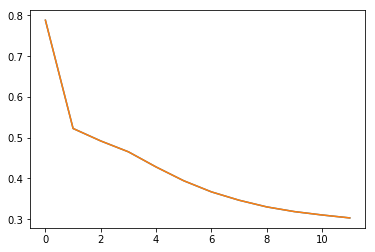

In [22]:
from matplotlib import pyplot as plt
plt.plot(weighted_errors)
plt.show()